In [10]:
import torch
import torch.nn as nn
import time
import utils
import torch.nn.functional as F
from torchsummary import summary

In [11]:
device  = torch.device("cuda")

torch.Size([50000, 3, 32, 32])
torch.Size([10000, 3, 32, 32])
tensor(0.4734)
tensor(0.2516)


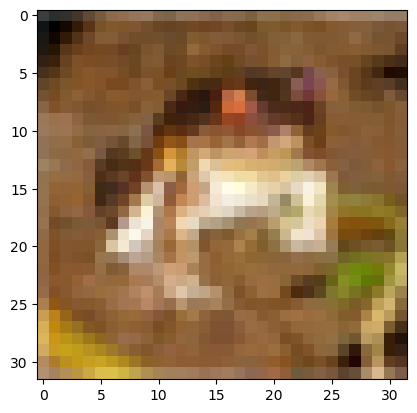

In [12]:
from utils import check_cifar_dataset_exists

data_path = check_cifar_dataset_exists()

train_data = torch.load(data_path + "cifar/train_data.pt")
train_label = torch.load(data_path + "cifar/train_label.pt")
test_data = torch.load(data_path+"cifar/test_data.pt")
test_label = torch.load(data_path+"cifar/test_label.pt")

# Data overview
print(train_data.size())
print(test_data.size())
mean = train_data.mean().to(device)
std = train_data.std().to(device)
print(mean.cpu())
print(std.cpu())

image = train_data[0]
utils.show(image)

In [13]:
class vgg(nn.Module):
    def __init__(self):
        super(vgg,self).__init__()
        # First block
        self.conv1a = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv1b = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2,2)
        # Second block
        self.conv2a = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2,2)
        #Third block
        self.conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2,2)
        #Fourth block
        self.con4a = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.con4b = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(2,2)
        #Fifth block
        self.linear1 = nn.Linear(2048, 4096)
        self.linear2 = nn.Linear(4096, 4096)
        self.linear3 = nn.Linear(4096, 10)
    
    def forward(self,x):
        # Block 1
        x = self.conv1a(x)
        x = F.relu(x)
        x = self.conv1b(x)
        x = F.relu(x)
        x = self.pool1(x)
        # Block 2
        x = self.conv2a(x)
        x = F.relu(x)
        x = self.conv2b(x)
        x = F.relu(x)
        x = self.pool2(x)
        # Block 3
        x = self.conv3a(x)
        x = F.relu(x)
        x = self.conv3b(x)
        x = F.relu(x)
        x = self.pool3(x)
        # Block 4
        x = self.con4a(x)
        x = F.relu(x)
        x = self.con4b(x)
        x = F.relu(x)
        x = self.pool4(x)
        # Block 4
        x = x.view(-1, 2048)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        
        return x


### Setting criterion

In [14]:
criterion = nn.CrossEntropyLoss()
bs = 128
lr = 0.25

# Evaluating function
def eval_on_test_data():
    running_error = 0
    num_batches = 0
    for count in range(0, 10000, bs):
        minibatch_data = test_data[count: count+bs].to(device)
        minibatch_label = test_label[count: count+bs].to(device)
        inputs = (minibatch_data-mean)/std
        scores = net(inputs)
        error = utils.get_error(scores, minibatch_label)
        running_error += error.item()
        num_batches += 1

    total_error = running_error/num_batches*100
    print("Error on test set {:.2f}%".format(total_error))

### Training model

In [15]:
net = vgg().to(device)

for epoch in range(20):
    if epoch in [10,14,20]:
        lr = lr/2
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    shuffled_indices = torch.randperm(50000)
    running_loss = 0
    running_error = 0
    num_batches = 0

    for count in range(0, 50000, bs):
        optimizer.zero_grad()
        minibatch_data = train_data[count:count+bs].to(device)
        minibatch_label = train_label[count:count+bs].to(device)

        inputs = (minibatch_data-mean)/std
        inputs.requires_grad_()

        scores = net(inputs)
        loss = criterion(scores, minibatch_label)
        loss.backward()
        optimizer.step()

        # Calculating stat
        running_loss += loss.item()
        error = utils.get_error(scores, minibatch_label)
        running_error += error.item()
        num_batches += 1

    total_error = running_error/num_batches*100
    total_loss = running_loss/num_batches
    print("Epoch:{}, Error:{:.2f}%, Loss:{:.2f}".format(epoch, total_error, total_loss))
    eval_on_test_data()
    print("--------------")

Epoch:0, Error:90.29%, Loss:2.30
Error on test set 89.90%
--------------
Epoch:1, Error:88.27%, Loss:2.29
Error on test set 89.97%
--------------
Epoch:2, Error:84.05%, Loss:2.20
Error on test set 74.39%
--------------
Epoch:3, Error:70.21%, Loss:1.88
Error on test set 65.25%
--------------
Epoch:4, Error:60.05%, Loss:1.62
Error on test set 56.19%
--------------
Epoch:5, Error:51.08%, Loss:1.39
Error on test set 46.23%
--------------
Epoch:6, Error:42.86%, Loss:1.18
Error on test set 42.38%
--------------
Epoch:7, Error:34.46%, Loss:0.97
Error on test set 36.41%
--------------
Epoch:8, Error:28.06%, Loss:0.79
Error on test set 32.84%
--------------
Epoch:9, Error:22.16%, Loss:0.63
Error on test set 28.31%
--------------
Epoch:10, Error:11.89%, Loss:0.34
Error on test set 25.18%
--------------
Epoch:11, Error:6.24%, Loss:0.19
Error on test set 26.08%
--------------
Epoch:12, Error:5.81%, Loss:0.17
Error on test set 25.61%
--------------
Epoch:13, Error:4.87%, Loss:0.14
Error on test set

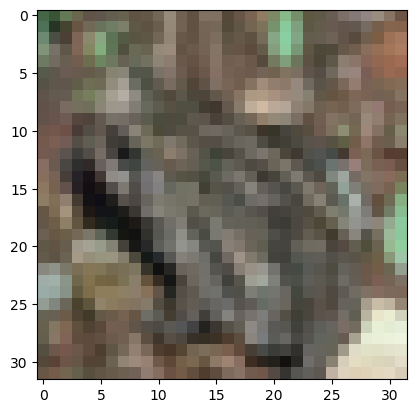

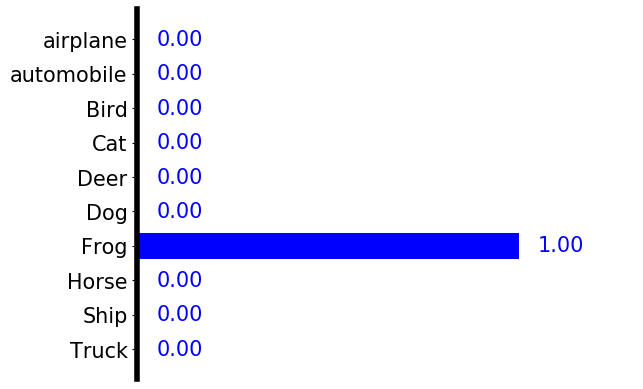

In [24]:
import random
idx = random.randint(0, 10000-1)
image = test_data[idx]
utils.show(image)

image = image.to(device)
image = (image-mean)/std
image = image.view(-1, 3, 32, 32)

scores = net(image)
probs = F.softmax(scores, dim=1)
utils.show_prob_cifar(probs.cpu())


In [25]:
summary(net, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
            Conv2d-2           [-1, 64, 32, 32]          36,928
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
            Conv2d-5          [-1, 128, 16, 16]         147,584
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
            Conv2d-8            [-1, 256, 8, 8]         590,080
         MaxPool2d-9            [-1, 256, 4, 4]               0
           Conv2d-10            [-1, 512, 4, 4]       1,180,160
           Conv2d-11            [-1, 512, 4, 4]       2,359,808
        MaxPool2d-12            [-1, 512, 2, 2]               0
           Linear-13                 [-1, 4096]       8,392,704
           Linear-14                 [-

In [28]:
import torchvision.models as models

summary(models.resnet50(False).cuda(), (3, 244, 244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]           4,096
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
           Conv2d-11          [-1, 256, 61, 61]          16,384
      BatchNorm2d-12          [-1, 256, 61, 61]             512
           Conv2d-13          [-1, 256, 61, 61]          16,384
      BatchNorm2d-14          [-1, 256,

In [29]:
summary(models.resnet34(False).cuda(), (3, 244, 244))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 122, 122]           9,408
       BatchNorm2d-2         [-1, 64, 122, 122]             128
              ReLU-3         [-1, 64, 122, 122]               0
         MaxPool2d-4           [-1, 64, 61, 61]               0
            Conv2d-5           [-1, 64, 61, 61]          36,864
       BatchNorm2d-6           [-1, 64, 61, 61]             128
              ReLU-7           [-1, 64, 61, 61]               0
            Conv2d-8           [-1, 64, 61, 61]          36,864
       BatchNorm2d-9           [-1, 64, 61, 61]             128
             ReLU-10           [-1, 64, 61, 61]               0
       BasicBlock-11           [-1, 64, 61, 61]               0
           Conv2d-12           [-1, 64, 61, 61]          36,864
      BatchNorm2d-13           [-1, 64, 61, 61]             128
             ReLU-14           [-1, 64,

In [ ]:
..